┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\jelte\.julia\packages\SciMLBase\Dwomw\src\integrator_interface.jl:626
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\jelte\.julia\packages\SciMLBase\Dwomw\src\integrator_interface.jl:626
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\jelte\.julia\packages\SciMLBase\Dwomw\src\integrator_interface.jl:626
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\jelte\.julia\packages\SciMLBase\Dwomw\src\integrator_interface.jl:626


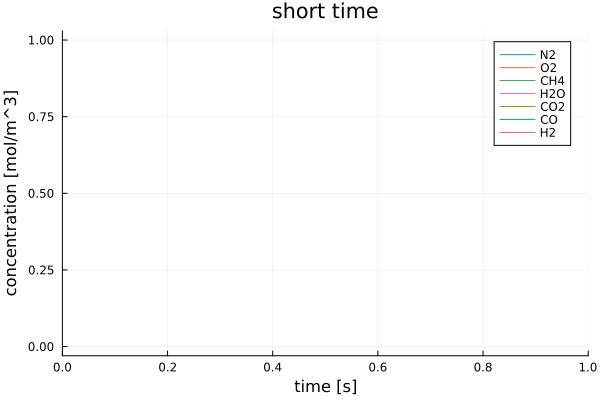

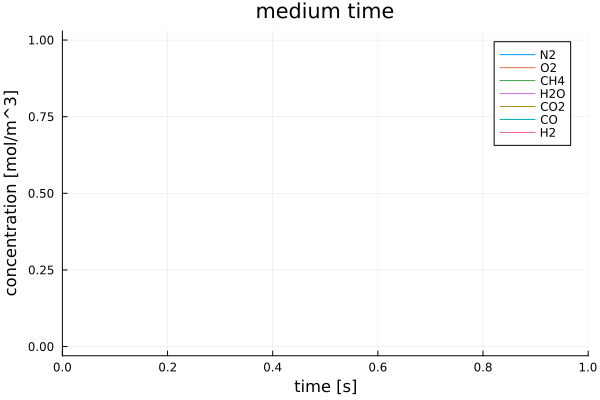

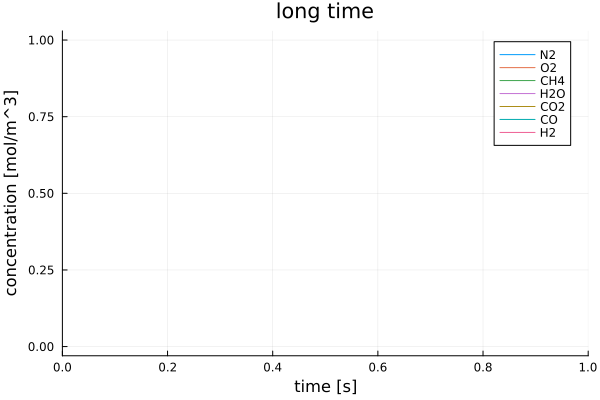

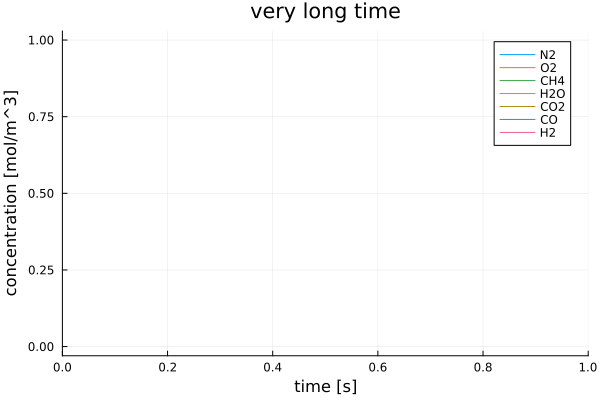

In [5]:
using DifferentialEquations
using Plots
using LinearAlgebra

# Temperature (assumed constant)
T = 1200 # K

# Initial species concentrations: N2, O2, CH4, H2O, CO2, CO, H2
X0 = [10.0, 8.0, 3.0, 0.0001, 0.0001, 0.0001, 0.0001] # mol/m^3

# Stoichiometric matrix
S = [0 -0.5 -1 0 0 1 2; 
     0 0 -1 -1 0 1 3; 
     0 -0.5 0 1 0 0 -1; 
     0 0.5 0 -1 0 0 1; 
     0 0 0 -1 1 -1 1; 
     0 0 0 1 -1 1 -1]

# Reaction rate function
function Arrhenius(T, X)
    R = 1.987204258640
    k  = zeros(6)
    k[1] = 0.44e12 * exp(-30000 / (R * T)) #from Jones & Lindstedt 1988
    k[2] = 0.30e9 * exp(-30000 / (R * T)) #from Jones & Lindstedt 1988
    k[3] = 0.25e17 * T^-1 * exp(-40000 / (R * T)) #from Jones & Lindstedt 1988
    k[4] = 0
    k[5] = 5.0e12 * exp(-67300/ (R * T)) #from Graven & Long 1953
    k[6] = 9.5e10 * exp(-57000/ (R * T)) #from Graven & Long 1953

    # Ensure non-negative concentrations
    Y = max.(X, 0)  # Avoid zero or negative concentrations for stability

    # Reaction rates
    r = zeros(6)
    r[1] = k[1] * Y[3]^0.5 * Y[2]^1.25 #from Jones & Lindstedt 1988
    r[2] = k[2] * Y[3] * Y[4] #from Jones & Lindstedt 1988
    r[3] = k[3] * Y[7]^0.5 * Y[2]^2.25 * Y[4]^-1 #from Jones & Lindstedt 1988
    r[4] = 0
    r[5] = k[5] * Y[6]^0.5 * Y[4] / (1 + 1.2e4 * Y[7]) #from Graven & Long 1953
    r[6] = k[6] * Y[7]^0.5 * Y[5] / (1 + 3.6e3 * Y[6]) #from Graven & Long 1953

    return r
end

# Differential equations function
function f!(dX, X, p, t)
    r = Arrhenius(T, X)
    dX .= S'*r
end

# Define and solve problems for different time spans
time_spans = [1e-9, 1e-6, 1e-3, 1]
titles = ["short time", "medium time", "long time","very long time"]

plots = []

for (tend, title) in zip(time_spans, titles)
    tspan = (0, tend)
    
    # Define ODE problem
    problem = ODEProblem(f!, X0, tspan)
    
    # Solve ODE problem with a stiff solver and tighter tolerances
    sol = solve(problem, alg_hints=[:stiff], reltol=1e-9, abstol=1e-12)

    X0=last(sol.u)

    # Plot solution obtained 
    plt = plot(sol, xlabel = "time [s]", ylabel = "concentration [mol/m^3]", title = title, label = ["N2" "O2" "CH4" "H2O" "CO2" "CO" "H2"])
    push!(plots, plt)
end

# Display all plots
for plt in plots
    display(plt)
end
